# Infer operator computation cost

This notebooks explores a way to predict the cost of operator Transpose based on some features.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## ONNX graph and measures

In [4]:
import numpy
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.algebra.onnx_ops import OnnxTranspose


def create_onnx_graph(perm=(0, 1, 2, 3), target_opset=14):
    tr = OnnxTranspose('X', perm=perm, output_names=['Y'], op_version=target_opset)
    return tr.to_onnx({'X': FloatTensorType([None] * len(perm))})


onx = create_onnx_graph()

%onnxview onx

In [5]:
from mlprodict.onnxrt import OnnxInference

onx = create_onnx_graph(perm=(1, 0, 3, 2))
oinf = OnnxInference(onx)
inputs = {'X': numpy.full((5, 6, 7, 8), 1, dtype=numpy.float32)}
res = oinf.run(inputs)['Y']
res.shape

(6, 5, 8, 7)

In [6]:
from onnxruntime import InferenceSession
sess = InferenceSession(onx.SerializeToString())
res = sess.run(None, inputs)[0]
res.shape

(6, 5, 8, 7)

In [7]:
from cpyquickhelper.numbers.speed_measure import measure_time

def measure_time_onnx(sess, X, number=50, repeat=30):
    inputs = {'X': X}
    return measure_time(lambda: sess.run(None, inputs), context=dict(sess=sess, inputs=inputs),
                        div_by_number=True, number=number, repeat=repeat)

X = numpy.random.random((3, 224, 224, 4)).astype(numpy.float32)
measure_time_onnx(sess, X)

{'average': 0.0024677738666666646,
 'deviation': 0.00022911153911864325,
 'min_exec': 0.0022292380000000023,
 'max_exec': 0.003265080000000005,
 'repeat': 30,
 'number': 50,
 'context_size': 232}

## Simulation to build a database

### Many dimensions, many permutations

In [8]:
from itertools import permutations
from tqdm import tqdm
from pandas import DataFrame


def process_shape(shape, rnd=False, number=50, repeat=30, bar=True):
    X = numpy.random.random(shape).astype(numpy.float32)
    obs = []
    perms = list(permutations(list(range(len(X.shape)))))
    baseline = None
    itergen = perms if (rnd or not bar) else tqdm(perms)
    for perm in itergen:
        if baseline is not None and rnd:
            if random.randint(0, 4) != 0:
                continue
        onx = create_onnx_graph(perm=perm)
        sess = InferenceSession(onx.SerializeToString())
        res = measure_time_onnx(sess, X, number=number, repeat=repeat)
        res['perm'] = perm
        res['shape'] = shape
        if baseline is None:
            baseline = res
        res["ratio"] = res["average"] / baseline["average"]
        res['dim'] = len(shape)
        obs.append(res)
    return DataFrame(obs).sort_values('average')

dfs = []
df = process_shape((12, 13, 15, 18))
dfs.append(df)
df

100%|██████████| 24/24 [00:04<00:00,  5.73it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
3,0.000044,0.000006,0.000039,0.000057,30,50,232,"(0, 2, 3, 1)","(12, 13, 15, 18)",0.750316,4
1,0.000048,0.000003,0.000045,0.000058,30,50,232,"(0, 1, 3, 2)","(12, 13, 15, 18)",0.820821,4
18,0.000049,0.000003,0.000045,0.000062,30,50,232,"(3, 0, 1, 2)","(12, 13, 15, 18)",0.823070,4
9,0.000049,0.000001,0.000048,0.000053,30,50,232,"(1, 2, 3, 0)","(12, 13, 15, 18)",0.830604,4
12,0.000051,0.000004,0.000039,0.000062,30,50,232,"(2, 0, 1, 3)","(12, 13, 15, 18)",0.861994,4
4,0.000052,0.000005,0.000047,0.000073,30,50,232,"(0, 3, 1, 2)","(12, 13, 15, 18)",0.889753,4
8,0.000054,0.000006,0.000044,0.000067,30,50,232,"(1, 2, 0, 3)","(12, 13, 15, 18)",0.909477,4
2,0.000054,0.000007,0.000049,0.000081,30,50,232,"(0, 2, 1, 3)","(12, 13, 15, 18)",0.922354,4
14,0.000057,0.000006,0.000046,0.000064,30,50,232,"(2, 1, 0, 3)","(12, 13, 15, 18)",0.972198,4
0,0.000059,0.000019,0.000034,0.000093,30,50,232,"(0, 1, 2, 3)","(12, 13, 15, 18)",1.000000,4


In [9]:
df = process_shape((43, 44, 45))
dfs.append(df)
df

100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
3,0.000073,0.000009,0.000062,0.000094,30,50,232,"(1, 2, 0)","(43, 44, 45)",0.985513,3
0,0.000074,0.000009,0.000065,0.000109,30,50,232,"(0, 1, 2)","(43, 44, 45)",1.000000,3
1,0.000077,0.000008,0.000069,0.000101,30,50,232,"(0, 2, 1)","(43, 44, 45)",1.032759,3
4,0.000097,0.000004,0.000083,0.000110,30,50,232,"(2, 0, 1)","(43, 44, 45)",1.300915,3
2,0.000113,0.000029,0.000061,0.000141,30,50,232,"(1, 0, 2)","(43, 44, 45)",1.515711,3
5,0.000375,0.000121,0.000292,0.000750,30,50,232,"(2, 1, 0)","(43, 44, 45)",5.054301,3


In [10]:
df = process_shape((3, 244, 244))
dfs.append(df)
df

100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
2,0.000100,0.000009,0.000090,0.000125,30,50,232,"(1, 0, 2)","(3, 244, 244)",0.955203,3
0,0.000105,0.000016,0.000078,0.000138,30,50,232,"(0, 1, 2)","(3, 244, 244)",1.000000,3
1,0.000123,0.000013,0.000108,0.000161,30,50,232,"(0, 2, 1)","(3, 244, 244)",1.178827,3
4,0.000124,0.000017,0.000108,0.000171,30,50,232,"(2, 0, 1)","(3, 244, 244)",1.185666,3
3,0.000151,0.000016,0.000136,0.000197,30,50,232,"(1, 2, 0)","(3, 244, 244)",1.438446,3
5,0.000672,0.000083,0.000626,0.001030,30,50,232,"(2, 1, 0)","(3, 244, 244)",6.418195,3


In [11]:
df = process_shape((3, 244, 244, 1))
dfs.append(df)
df

100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
4,0.000092,0.000008,0.000078,0.000107,30,50,232,"(0, 3, 1, 2)","(3, 244, 244, 1)",0.859903,4
0,0.000107,0.000018,0.000084,0.000157,30,50,232,"(0, 1, 2, 3)","(3, 244, 244, 1)",1.000000,4
6,0.000124,0.000068,0.000088,0.000323,30,50,232,"(1, 0, 2, 3)","(3, 244, 244, 1)",1.162456,4
12,0.000126,0.000017,0.000107,0.000185,30,50,232,"(2, 0, 1, 3)","(3, 244, 244, 1)",1.180996,4
3,0.000130,0.000009,0.000120,0.000163,30,50,232,"(0, 2, 3, 1)","(3, 244, 244, 1)",1.210077,4
18,0.000137,0.000047,0.000090,0.000250,30,50,232,"(3, 0, 1, 2)","(3, 244, 244, 1)",1.276642,4
1,0.000147,0.000017,0.000106,0.000175,30,50,232,"(0, 1, 3, 2)","(3, 244, 244, 1)",1.369978,4
8,0.000185,0.000017,0.000164,0.000246,30,50,232,"(1, 2, 0, 3)","(3, 244, 244, 1)",1.725391,4
9,0.000189,0.000044,0.000142,0.000265,30,50,232,"(1, 2, 3, 0)","(3, 244, 244, 1)",1.766905,4
2,0.000201,0.000054,0.000121,0.000289,30,50,232,"(0, 2, 1, 3)","(3, 244, 244, 1)",1.878802,4


In [12]:
df = process_shape((1, 244, 244, 3))
dfs.append(df)
df

100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
8,0.000092,0.000014,0.000078,0.000132,30,50,232,"(1, 2, 0, 3)","(1, 244, 244, 3)",0.753009,4
6,0.000098,0.000013,0.000083,0.000142,30,50,232,"(1, 0, 2, 3)","(1, 244, 244, 3)",0.802808,4
9,0.000107,0.000018,0.000075,0.000137,30,50,232,"(1, 2, 3, 0)","(1, 244, 244, 3)",0.873932,4
3,0.000115,0.000015,0.000092,0.000147,30,50,232,"(0, 2, 3, 1)","(1, 244, 244, 3)",0.940606,4
0,0.000122,0.000028,0.000094,0.000201,30,50,232,"(0, 1, 2, 3)","(1, 244, 244, 3)",1.000000,4
1,0.000194,0.000036,0.000160,0.000311,30,50,232,"(0, 1, 3, 2)","(1, 244, 244, 3)",1.585479,4
4,0.000195,0.000019,0.000163,0.000258,30,50,232,"(0, 3, 1, 2)","(1, 244, 244, 3)",1.598770,4
18,0.000235,0.000058,0.000172,0.000345,30,50,232,"(3, 0, 1, 2)","(1, 244, 244, 3)",1.923654,4
2,0.000408,0.000156,0.000229,0.000718,30,50,232,"(0, 2, 1, 3)","(1, 244, 244, 3)",3.345406,4
12,0.000513,0.000215,0.000300,0.001430,30,50,232,"(2, 0, 1, 3)","(1, 244, 244, 3)",4.205477,4


In [13]:
df = process_shape((3, 244, 244, 3), number=15, repeat=15)
dfs.append(df)
df

100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
0,0.001088,0.000085,0.000986,0.001291,15,15,232,"(0, 1, 2, 3)","(3, 244, 244, 3)",1.000000,4
4,0.001227,0.000088,0.001152,0.001474,15,15,232,"(0, 3, 1, 2)","(3, 244, 244, 3)",1.128126,4
18,0.001277,0.000118,0.001079,0.001490,15,15,232,"(3, 0, 1, 2)","(3, 244, 244, 3)",1.173721,4
6,0.001311,0.000320,0.001007,0.001925,15,15,232,"(1, 0, 2, 3)","(3, 244, 244, 3)",1.205182,4
1,0.001415,0.000307,0.001200,0.002498,15,15,232,"(0, 1, 3, 2)","(3, 244, 244, 3)",1.300901,4
3,0.001426,0.000221,0.001191,0.001863,15,15,232,"(0, 2, 3, 1)","(3, 244, 244, 3)",1.311361,4
9,0.001510,0.000432,0.001132,0.002417,15,15,232,"(1, 2, 3, 0)","(3, 244, 244, 3)",1.388068,4
8,0.001552,0.000030,0.001500,0.001602,15,15,232,"(1, 2, 0, 3)","(3, 244, 244, 3)",1.427105,4
12,0.001724,0.000193,0.001470,0.002142,15,15,232,"(2, 0, 1, 3)","(3, 244, 244, 3)",1.585155,4
2,0.001790,0.000191,0.001566,0.002238,15,15,232,"(0, 2, 1, 3)","(3, 244, 244, 3)",1.645717,4


In [14]:
df = process_shape((3, 244, 244, 6), number=15, repeat=15)
dfs.append(df)
df

100%|██████████| 24/24 [00:34<00:00,  1.43s/it]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
1,0.002249,0.000144,0.002067,0.002627,15,15,232,"(0, 1, 3, 2)","(3, 244, 244, 6)",0.606961,4
3,0.002711,0.000171,0.002458,0.002995,15,15,232,"(0, 2, 3, 1)","(3, 244, 244, 6)",0.731795,4
12,0.002773,0.000683,0.002260,0.004103,15,15,232,"(2, 0, 1, 3)","(3, 244, 244, 6)",0.748578,4
4,0.002953,0.000677,0.002187,0.004132,15,15,232,"(0, 3, 1, 2)","(3, 244, 244, 6)",0.797062,4
2,0.003232,0.000963,0.002303,0.005088,15,15,232,"(0, 2, 1, 3)","(3, 244, 244, 6)",0.872427,4
6,0.003363,0.000372,0.002883,0.004025,15,15,232,"(1, 0, 2, 3)","(3, 244, 244, 6)",0.907834,4
8,0.003397,0.000237,0.002886,0.003846,15,15,232,"(1, 2, 0, 3)","(3, 244, 244, 6)",0.917011,4
9,0.003653,0.000874,0.002567,0.005244,15,15,232,"(1, 2, 3, 0)","(3, 244, 244, 6)",0.986071,4
14,0.003697,0.000186,0.003495,0.004150,15,15,232,"(2, 1, 0, 3)","(3, 244, 244, 6)",0.997901,4
0,0.003705,0.000797,0.002111,0.005164,15,15,232,"(0, 1, 2, 3)","(3, 244, 244, 6)",1.000000,4


### Random cases

In [15]:
import random

if False:  # comment out for more training data
    for i in tqdm(range(0, 30)):
        dim = random.randint(3, 5)
        total = 1e8
        while total > 1e6 or total < 0:
            if dim == 3:
                shape = [random.randint(3, 64), random.randint(3, 224), random.randint(3, 64)]
            elif dim == 4:
                shape = (
                    [random.randint(3, 8)] + 
                    [random.randint(16, 224) for d in range(2)] +
                    [random.randint(16, 64)])
            elif dim == 5:
                shape = (
                    [random.randint(3, 8)] + 
                    [random.randint(16, 32) for d in range(3)] +
                    [random.randint(16, 64)])
            else:
                raise NotImplementedError()
            ashape = numpy.array(shape, dtype=numpy.float64)
            total = numpy.prod(ashape)

        if total > 1000000:
            number, repeat = 2, 2
        elif total > 800000:
            number, repeat = 3, 3
        elif total > 500000:
            number, repeat = 5, 5
        elif total > 200000:
            number, repeat = 7, 7
        else:
            number, repeat = 10, 10

        df = process_shape(tuple(shape), number=number, repeat=repeat, bar=False)
        dfs.append(df)

        for i in range(len(shape)):
            shape2 = shape.copy()
            shape2[i] = 1
            df = process_shape(tuple(shape), number=number, repeat=repeat, bar=False)
            dfs.append(df)
    
len(dfs)

7

In [16]:
import pandas

data = pandas.concat(dfs, axis=0).reset_index(drop=True)
data.tail()

,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
127,0.010339,0.002789,0.005878,0.018301,15,15,232,"(0, 3, 2, 1)","(3, 244, 244, 6)",2.790823,4
128,0.010677,0.001457,0.008504,0.014070,15,15,232,"(2, 3, 1, 0)","(3, 244, 244, 6)",2.882191,4
129,0.012421,0.003052,0.007818,0.018106,15,15,232,"(3, 2, 1, 0)","(3, 244, 244, 6)",3.352770,4
130,0.013432,0.004496,0.006536,0.021250,15,15,232,"(3, 2, 0, 1)","(3, 244, 244, 6)",3.625680,4
131,0.014579,0.004026,0.007144,0.020739,15,15,232,"(3, 0, 2, 1)","(3, 244, 244, 6)",3.935483,4


In [17]:
data.shape

(132, 11)

In [18]:
data[['dim', 'shape', 'ratio']].groupby(['dim', 'shape']).agg({'ratio': [min, max, numpy.mean, numpy.median]})

ratio                               
                           min        max      mean    median
dim shape                                                    
3   (3, 244, 244)     0.955203   6.418195  2.029389  1.182247
    (43, 44, 45)      0.985513   5.054301  1.814867  1.166837
4   (1, 244, 244, 3)  0.753009  11.740772  5.023301  5.013162
    (3, 244, 244, 1)  0.859903  10.530182  4.882680  5.477356
    (3, 244, 244, 3)  1.000000   5.125597  2.481287  2.372651
    (3, 244, 244, 6)  0.606961   3.935483  1.704169  1.465209
    (12, 13, 15, 18)  0.750316   3.640132  1.866691  2.319191

## features



### Computing the features

In [19]:
def _edit_distance(mot1, mot2):
    dist = {(-1, -1): 0}
    pred = {(-1, -1): None}
    if len(mot1) == 0:
        for j, d in enumerate(mot2):
            dist[-1, j] = dist[-1, j - 1] + 1
            pred[-1, j] = (-1, j - 1)
            dist[j, -1] = dist[j - 1, -1] + 1
            pred[j, -1] = (j - 1, -1)
    for i, c in enumerate(mot1):
        dist[i, -1] = dist[i - 1, -1] + 1
        pred[i, -1] = (i - 1, -1)
        dist[-1, i] = dist[-1, i - 1] + 1
        pred[-1, i] = (-1, i - 1)
        for j, d in enumerate(mot2):
            opt = []
            if (i - 1, j) in dist:
                x = dist[i - 1, j] + 1
                opt.append((x, (i - 1, j)))
            if (i, j - 1) in dist:
                x = dist[i, j - 1] + 1
                opt.append((x, (i, j - 1)))
            if (i - 1, j - 1) in dist:
                x = dist[i - 1, j - 1] + (1 if c != d else 0)
                opt.append((x, (i - 1, j - 1)))
            mi = min(opt)
            dist[i, j] = mi[0]
            pred[i, j] = mi[1]

    return dist[len(mot1) - 1, len(mot2) - 1]

_edit_distance("abdc", "cbda")

2

In [20]:
_edit_distance((0, 1, 2, 3), (0, 2, 1, 3))

2

In [21]:
from math import log


def _is_rotation(perm):
    t = tuple(perm)
    c = list(range(len(perm)))
    for i in range(len(c)):
        for k in range(len(c)):
            c[k] = (k + i) % len(c)
        if t == tuple(c):
            return True
    return False


def _relu(x, origin=0):
    return origin if x < origin else x


def compute_features(shape, perm):    
    total = numpy.prod(numpy.array(shape, dtype=numpy.int64))
    
    begin = 1
    dbegin = 0
    for i, p in enumerate(perm):
        if p != i:
            break
        dbegin += 1
        begin *= shape[i]
        
    end = 1
    dend = 0
    for i in range(len(perm)-1, -1, -1):
        if perm[i] != i:
            break
        dend += 1
        end *= shape[i]
    
    dis_cont = 0
    for i in range(1, len(shape)):
        if perm[i] != perm[i-1] + 1:
            dis_cont += 1
    
    middle = max(1, int(total / (end * begin)))
    feat = dict(size=total, begin=begin, end=end, middle=middle,
                dim=len(shape), discont=dis_cont)

    for c in [16, 32]:
        feat["end%d" % c] = _relu(end, c)
    
    keys = list(feat)
    for k in keys:
        if k in {'dim', 'cpu', 'size'}:
            continue
        feat['r%s' % k] = float(feat[k] / total)
    
    for c in [2, 4, 8, 16, 32, 64]:
        feat["iend%d" % c] = float(end >= c)
        feat["ibegin%d" % c] = float(begin >= c)
    
    # feat['CST'] = 1
    feat['CST_'] = -1
    feat['dbegin'] = - dbegin
    feat['dend'] = - dend
    
    keys = list(feat)
    for k in keys:
        if k.startswith('end') or k.startswith('begin'):
            feat[k] = - feat[k]
        elif k.startswith('rend') or k.startswith('rbegin'):
            feat[k] = - feat[k]
        elif k.startswith('iend') or k.startswith('ibegin'):
            feat[k] = - feat[k]
        elif k == "rdiscont":
            feat[k] = - feat[k]

    idp = list(range(len(perm)))
    feat["rot"] = -1 if _is_rotation(perm) else 0
    feat["rev"] = 1 if perm == tuple(idp[::-1]) else 0
    feat["edit"] = _edit_distance(idp, perm)
    feat["redit"] = feat["edit"] / len(idp)
    return feat


compute_features((3, 5, 7), (0, 1, 2))

{'size': 105,
 'begin': -105,
 'end': -105,
 'middle': 1,
 'dim': 3,
 'discont': 0,
 'end16': -105,
 'end32': -105,
 'rbegin': -1.0,
 'rend': -1.0,
 'rmiddle': 0.009523809523809525,
 'rdiscont': -0.0,
 'rend16': -1.0,
 'rend32': -1.0,
 'iend2': -1.0,
 'ibegin2': -1.0,
 'iend4': -1.0,
 'ibegin4': -1.0,
 'iend8': -1.0,
 'ibegin8': -1.0,
 'iend16': -1.0,
 'ibegin16': -1.0,
 'iend32': -1.0,
 'ibegin32': -1.0,
 'iend64': -1.0,
 'ibegin64': -1.0,
 'CST_': -1,
 'dbegin': -3,
 'dend': -3,
 'rot': -1,
 'rev': 0,
 'edit': 0,
 'redit': 0.0}

In [22]:
compute_features((3, 5, 7), (2, 1, 0))

{'size': 105,
 'begin': -1,
 'end': -1,
 'middle': 105,
 'dim': 3,
 'discont': 2,
 'end16': -16,
 'end32': -32,
 'rbegin': -0.009523809523809525,
 'rend': -0.009523809523809525,
 'rmiddle': 1.0,
 'rdiscont': -0.01904761904761905,
 'rend16': -0.1523809523809524,
 'rend32': -0.3047619047619048,
 'iend2': -0.0,
 'ibegin2': -0.0,
 'iend4': -0.0,
 'ibegin4': -0.0,
 'iend8': -0.0,
 'ibegin8': -0.0,
 'iend16': -0.0,
 'ibegin16': -0.0,
 'iend32': -0.0,
 'ibegin32': -0.0,
 'iend64': -0.0,
 'ibegin64': -0.0,
 'CST_': -1,
 'dbegin': 0,
 'dend': 0,
 'rot': 0,
 'rev': 1,
 'edit': 2,
 'redit': 0.6666666666666666}

In [23]:
compute_features((3, 5, 7), (1, 2, 0))

{'size': 105,
 'begin': -1,
 'end': -1,
 'middle': 105,
 'dim': 3,
 'discont': 1,
 'end16': -16,
 'end32': -32,
 'rbegin': -0.009523809523809525,
 'rend': -0.009523809523809525,
 'rmiddle': 1.0,
 'rdiscont': -0.009523809523809525,
 'rend16': -0.1523809523809524,
 'rend32': -0.3047619047619048,
 'iend2': -0.0,
 'ibegin2': -0.0,
 'iend4': -0.0,
 'ibegin4': -0.0,
 'iend8': -0.0,
 'ibegin8': -0.0,
 'iend16': -0.0,
 'ibegin16': -0.0,
 'iend32': -0.0,
 'ibegin32': -0.0,
 'iend64': -0.0,
 'ibegin64': -0.0,
 'CST_': -1,
 'dbegin': 0,
 'dend': 0,
 'rot': -1,
 'rev': 0,
 'edit': 2,
 'redit': 0.6666666666666666}

### Computing the features for all simulations

In [24]:
def compute_features_dataframe(df):
    
    def merge(row):
        feat = compute_features(row['shape'], row['perm'])
        feat['yt'] = row['average']
        feat['yr'] = row['ratio']
        return feat
    
    rows = []
    for i in tqdm(range(df.shape[0])):
        rows.append(dict(shape=df.loc[i, "shape"], perm=df.loc[i, "perm"],
                         average=df.loc[i, "average"], ratio=df.loc[i, "ratio"]))
    obs = []
    for row in tqdm(rows):
        obs.append(merge(row))
    return DataFrame(obs)

fdata = compute_features_dataframe(data)
col_sort = list(sorted(fdata.columns))
fdata = fdata[col_sort]
fdata.tail()

100%|██████████| 132/132 [00:00<00:00, 3601.95it/s]


,CST_,begin,dbegin,dend,dim,discont,edit,end,end16,end32,...,redit,rend,rend16,rend32,rev,rmiddle,rot,size,yr,yt
127,-1,-3,-1,0,4,3,2,-1,-16,-32,...,0.50,-9.331422e-07,-0.000015,-0.00003,0,0.333333,0,1071648,2.790823,0.010339
128,-1,-1,0,0,4,2,4,-1,-16,-32,...,1.00,-9.331422e-07,-0.000015,-0.00003,0,1.000000,0,1071648,2.882191,0.010677
129,-1,-1,0,0,4,3,4,-1,-16,-32,...,1.00,-9.331422e-07,-0.000015,-0.00003,1,1.000000,0,1071648,3.352770,0.012421
130,-1,-1,0,0,4,2,4,-1,-16,-32,...,1.00,-9.331422e-07,-0.000015,-0.00003,0,1.000000,0,1071648,3.625680,0.013432
131,-1,-1,0,0,4,3,3,-1,-16,-32,...,0.75,-9.331422e-07,-0.000015,-0.00003,0,1.000000,0,1071648,3.935483,0.014579


### correlations

In [25]:
fdata.corr()

,CST_,begin,dbegin,dend,dim,discont,edit,end,end16,end32,...,redit,rend,rend16,rend32,rev,rmiddle,rot,size,yr,yt
CST_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
begin,NaN,1.000000,0.596816,0.596414,0.014118,0.404952,0.405175,0.999998,0.999998,0.999998,...,0.418022,0.681573,0.681573,0.681573,0.038216,0.256349,0.325594,-0.133581,0.127658,-0.008816
dbegin,NaN,0.596816,1.000000,0.676899,0.077162,0.486887,0.669598,0.596384,0.596374,0.596363,...,0.690333,0.831887,0.831895,0.831903,0.111636,0.605990,0.298090,0.016411,0.291318,0.139951
dend,NaN,0.596414,0.676899,1.000000,0.077162,0.486887,0.669598,0.596936,0.596907,0.596881,...,0.690333,0.833059,0.832975,0.832924,0.111636,0.623582,0.298090,0.016411,0.305489,0.155098
dim,NaN,0.014118,0.077162,0.077162,1.000000,0.305320,0.272614,0.014153,0.014145,0.014135,...,0.115902,0.160407,0.160417,0.160414,-0.160357,0.106693,0.240946,0.212685,0.138961,0.192305
discont,NaN,0.404952,0.486887,0.486887,0.305320,1.000000,0.531254,0.404971,0.404961,0.404948,...,0.504206,0.594219,0.594226,0.594223,0.150144,0.225854,0.823937,0.064937,0.388140,0.203342
edit,NaN,0.405175,0.669598,0.669598,0.272614,0.531254,1.000000,0.405223,0.405204,0.405189,...,0.984655,0.594688,0.594639,0.594619,0.208568,0.652532,0.338994,0.057981,0.464225,0.283262
end,NaN,0.999998,0.596384,0.596936,0.014153,0.404971,0.405223,1.000000,1.000000,1.000000,...,0.418062,0.681565,0.681565,0.681565,0.038236,0.256479,0.325559,-0.133665,0.127730,-0.008844
end16,NaN,0.999998,0.596374,0.596907,0.014145,0.404961,0.405204,1.000000,1.000000,1.000000,...,0.418044,0.681550,0.681550,0.681550,0.038231,0.256451,0.325557,-0.133671,0.127716,-0.008852
end32,NaN,0.999998,0.596363,0.596881,0.014135,0.404948,0.405189,1.000000,1.000000,1.000000,...,0.418029,0.681533,0.681533,0.681533,0.038228,0.256430,0.325552,-0.133677,0.127707,-0.008859


In [26]:
fdata.corr()['yt']

CST_             NaN
begin      -0.008816
dbegin      0.139951
dend        0.155098
dim         0.192305
discont     0.203342
edit        0.283262
end        -0.008844
end16      -0.008852
end32      -0.008859
ibegin16    0.136416
ibegin2     0.109929
ibegin32    0.136416
ibegin4     0.179014
ibegin64    0.124459
ibegin8     0.179014
iend16      0.182267
iend2       0.146321
iend32      0.139099
iend4       0.127468
iend64      0.127728
iend8       0.182267
middle      0.821357
rbegin      0.095471
rdiscont    0.386893
redit       0.256097
rend        0.095557
rend16      0.095755
rend32      0.095996
rev         0.094260
rmiddle     0.195497
rot         0.126195
size        0.805926
yr         -0.013907
yt          1.000000
Name: yt, dtype: float64

We check the sign of the correlations of all features with *yt*. If it is positive, increasing the feature increases the processing time. We try to get only positive correlations. *end* is the flattened last dimensions left unchanged by the permutation. The bigger it is, the faster the transposition is. That's why the function computing all features multiplies this number by `-1` to get a feature positively correlated to the processing time. *end16* is equal to *end* when `end<-16` and `-16` when `end>=-16`. This is a simplification of the cost of moving data from memory to cache L1. This cost is linear when the data to move is big enough, but almost constant for small chunks.

## Linear regression

We choose a linear regression because the prediction are not limited. The training set does not include all configuration and surely does not include all possible high value the model may have to predict.

The goal is not necessarily to predict the fastest permutation but to predict the processing time as the goal is to find the best combination of transpositions in a ONNX graph (einsum). The final goal is to predict which graphs optimizes a series of transpositions.

The target could be the processing time or the logarithm of this time. However, making mistakes on small times is not an issue but errors on high processing time is not a good thing.

We could also try to predict a ratio *transposition time /copy time* but it still gives more important to small matrix size.  

Many variables are correlated. Variables should be selected.

### Dataset

In [27]:
X = fdata.drop(["yt", "yr"], axis=1)
x_names = list(X.columns)
yt = fdata['yt'] * 1000

In [28]:
numpy.mean(yt)

1.8809171132996723

### Simple model 

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error

pipe = make_pipeline(StandardScaler(with_mean=False), LinearRegression(fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'reg'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs = [coef]
coef["r2"], coef['mae']

(0.8157414076410756, 0.6368865305095469)

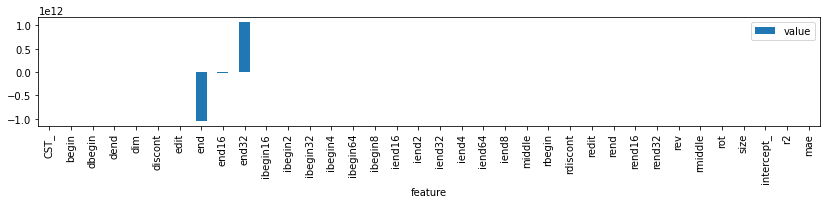

In [30]:
df = DataFrame([(k, v) for k, v in coef.items() if k not in {'name', 'model'}],
                columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2));

In [31]:
df

,value
feature,
CST_,-3.076618e+08
begin,-2.941725e+01
dbegin,-1.854147e-01
dend,-9.638954e-02
dim,-1.037599e-01
discont,5.204404e-01
edit,3.582481e-01
end,-1.046584e+12
end16,-2.278042e+10


Coefficients associated to features *end*, *end16* are almost opposed and it would better to get a model which keeps only one.

### Quantile Regression

In [32]:
from mlinsights.mlmodel import QuantileLinearRegression
pipe = make_pipeline(StandardScaler(with_mean=False), QuantileLinearRegression(fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'med'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs.append(coef)
coef["r2"], coef['mae']

(0.7924498414927943, 0.5679387557069854)

In [33]:
DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")

,value
feature,
CST_,1433409.249051
begin,27.13405
dbegin,0.07931
dend,0.087576
dim,0.006919
discont,0.413378
edit,0.186032
end,4876069525.422424
end16,106134745.367844


### Lasso

To select features.

In [34]:
from sklearn.linear_model import Lasso

scores = []
models = []
for a in tqdm([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2.]):
    alpha = a * 1.
    pipe = make_pipeline(
        StandardScaler(with_mean=False),
        Lasso(alpha=alpha, fit_intercept=False, max_iter=5000))
    pipe.fit(X, yt)
    pred = numpy.maximum(pipe.predict(X), 0)
    model = pipe.steps[1][1]
    scores.append(dict(r2=r2_score(yt, pred), mae=mean_absolute_error(yt, pred),
                       alpha=alpha, null=(numpy.abs(model.coef_) < 1e-6).sum(),
                       n=len(model.coef_)))
    models.append(pipe)
    if alpha >= 0.01 and alpha <= 0.2:
        coef = {k: v for k, v in zip(X.columns, pipe.steps[1][1].coef_)}
        coef['name'] = "Lasso-%f" % alpha
        coef['model'] = pipe
        coef['r2'] = r2_score(yt, pred)
        coef['mae'] = mean_absolute_error(yt, pred)
        coefs.append(coef)
    
DataFrame(scores)

100%|██████████| 13/13 [00:00<00:00, 69.97it/s]


,r2,mae,alpha,null,n
0,0.809704,0.629480,0.001,4,33
1,0.807546,0.629886,0.010,10,33
2,0.782541,0.676499,0.100,23,33
3,0.766911,0.680344,0.200,28,33
4,0.751546,0.703684,0.300,29,33
5,0.738223,0.742962,0.400,30,33
6,0.730937,0.735958,0.500,31,33
7,0.718437,0.758143,0.600,30,33
8,0.701329,0.800503,0.700,30,33
9,0.681590,0.848549,0.800,30,33


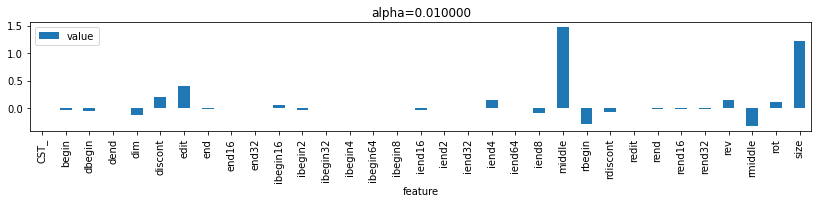

In [35]:
coef = {k: v for k, v in zip(X.columns, models[1].steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="alpha=%f" % scores[1]["alpha"]);

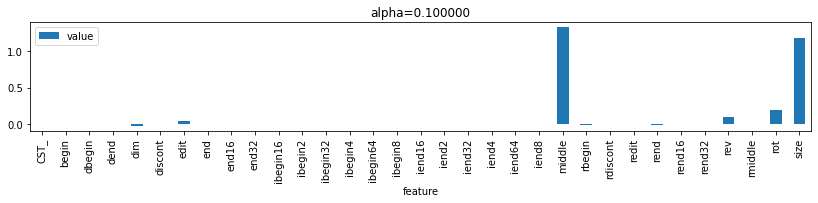

In [36]:
coef = {k: v for k, v in zip(X.columns, models[2].steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="alpha=%f" % scores[2]["alpha"]);

### Linear regression with positive weights

In [37]:
pipe = make_pipeline(StandardScaler(with_mean=False), LinearRegression(positive=True, fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'pos'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs.append(coef)
coef["r2"], coef['mae']

(0.7905447080626958, 0.6768663007518693)

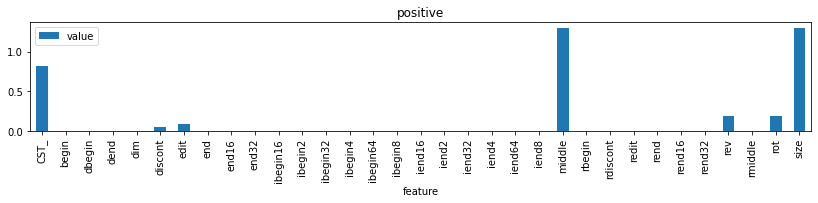

In [38]:
coef = {k: v for k, v in zip(X.columns, pipe.steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="positive");

### Quantile regression with positive weights

In [39]:
pipe = make_pipeline(StandardScaler(with_mean=False), QuantileLinearRegression(positive=True, fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'medpos'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs.append(coef)
coef["r2"], coef['mae']

(0.752689515971656, 0.6468340444504788)

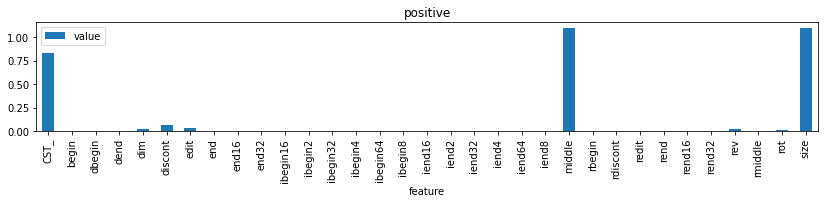

In [40]:
coef = {k: v for k, v in zip(X.columns, pipe.steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="positive");

### Summary

In [41]:
dfcoef = DataFrame(coefs)
dfcoef[::-1].T

,6,5,4,3,2,1,0
CST_,0.829482,0.821048,0.0,0.0,0.0,1433409.249051,-307661768.128088
begin,0.0,0.0,-0.0,-0.0,-0.03443,27.13405,-29.417247
dbegin,0.0,0.0,-0.0,-0.0,-0.044705,0.07931,-0.185415
dend,0.0,0.0,-0.0,-0.0,-0.0,0.087576,-0.09639
dim,0.023846,0.0,-0.014763,-0.030446,-0.120949,0.006919,-0.10376
discont,0.060636,0.056297,0.0,0.0,0.210421,0.413378,0.52044
edit,0.03823,0.094856,0.0,0.0418,0.396052,0.186032,0.358248
end,0.0,0.0,-0.0,-0.0,-0.007053,4876069525.422424,-1046583604803.358887
end16,0.0,0.0,-0.0,-0.0,-0.000036,106134745.367844,-22780416305.902706
end32,0.0,0.0,-0.0,-0.0,-0.00004,-4982003112.711292,1069320839370.567505


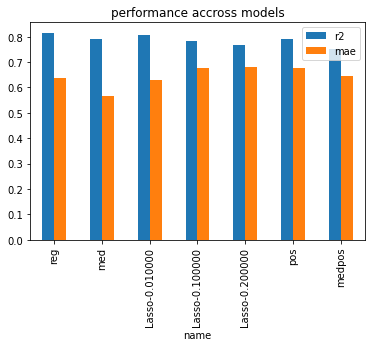

In [42]:
dfcoef[["name", "r2", "mae"]].set_index('name').plot(kind="bar", title="performance accross models");

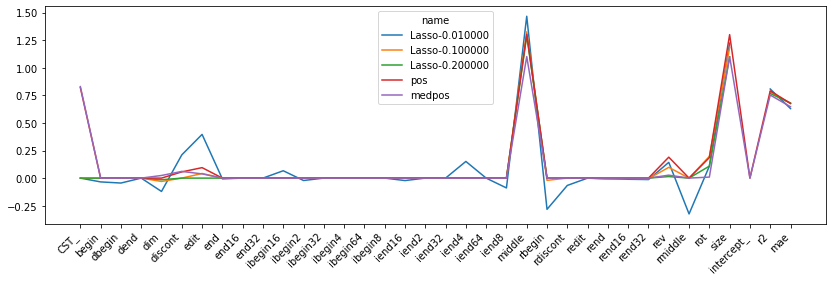

In [43]:
import matplotlib.pyplot as plt

dfp = dfcoef.drop(['name', 'model'], axis=1).T.drop([0, 1], axis=1).copy()
dfp.columns = dfcoef['name'][2:]
ax = dfp.plot(figsize=(14, 4), kind="line")
ax.set_xticks(numpy.arange(0, dfp.shape[0]))
ax.set_xticklabels(dfp.index)
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

## Investigation

In [44]:
data_err = data.drop(["context_size", "repeat"], axis=1).copy()
data_err['predict'] = numpy.maximum(coefs[0]['model'].predict(X), 0) / 1000
data_err['err'] = (data_err['predict'] - data_err['average'])
data_err['abserr'] = numpy.abs(data_err['predict'] - data_err['average'])
data_err['rel'] = (data_err['predict'] - data_err['average']) / data_err['average']
s = data_err.sort_values('abserr')
pandas.concat([s.head(n=10), s.tail(n=10)])

,average,deviation,min_exec,max_exec,number,perm,shape,ratio,dim,predict,err,abserr,rel
28,0.000113,0.000029,0.000061,0.000141,50,"(1, 0, 2)","(43, 44, 45)",1.515711,3,0.000113,1.251063e-07,1.251063e-07,0.001111
55,0.000893,0.000212,0.000646,0.001477,50,"(2, 3, 1, 0)","(3, 244, 244, 1)",8.339926,4,0.000893,-2.410649e-07,2.410649e-07,-0.000270
26,0.000077,0.000008,0.000069,0.000101,50,"(0, 2, 1)","(43, 44, 45)",1.032759,3,0.000077,4.172780e-07,4.172780e-07,0.005440
39,0.000126,0.000017,0.000107,0.000185,50,"(2, 0, 1, 3)","(3, 244, 244, 1)",1.180996,4,0.000115,-1.179187e-05,1.179187e-05,-0.093246
66,0.000195,0.000019,0.000163,0.000258,50,"(0, 3, 1, 2)","(1, 244, 244, 3)",1.598770,4,0.000210,1.510728e-05,1.510728e-05,0.077417
50,0.000692,0.000136,0.000529,0.001021,50,"(0, 3, 2, 1)","(3, 244, 244, 1)",6.460759,4,0.000709,1.714180e-05,1.714180e-05,0.024778
76,0.000824,0.000288,0.000515,0.001879,50,"(1, 3, 2, 0)","(1, 244, 244, 3)",6.752663,4,0.000843,1.902846e-05,1.902846e-05,0.023087
54,0.000818,0.000278,0.000625,0.001522,50,"(2, 1, 3, 0)","(3, 244, 244, 1)",7.634646,4,0.000843,2.572773e-05,2.572773e-05,0.031471
1,0.000048,0.000003,0.000045,0.000058,50,"(0, 1, 3, 2)","(12, 13, 15, 18)",0.820821,4,0.000000,-4.837787e-05,4.837787e-05,-1.000000
2,0.000049,0.000003,0.000045,0.000062,50,"(3, 0, 1, 2)","(12, 13, 15, 18)",0.823070,4,0.000000,-4.851040e-05,4.851040e-05,-1.000000


All big errors are negative. The model seems to give a lower value for all big errors. These errors may be outliers, the processor was busy doing something else at that time.

In [45]:
s = data_err.sort_values('predict')
pandas.concat([s.head(n=10), s.tail(n=10)])

,average,deviation,min_exec,max_exec,number,perm,shape,ratio,dim,predict,err,abserr,rel
20,0.000158,0.000021,0.000127,0.000192,50,"(3, 0, 2, 1)","(12, 13, 15, 18)",2.684876,4,0.000000,-0.000158,0.000158,-1.000000
42,0.000147,0.000017,0.000106,0.000175,50,"(0, 1, 3, 2)","(3, 244, 244, 1)",1.369978,4,0.000000,-0.000147,0.000147,-1.000000
34,0.000151,0.000016,0.000136,0.000197,50,"(1, 2, 0)","(3, 244, 244)",1.438446,3,0.000000,-0.000151,0.000151,-1.000000
33,0.000124,0.000017,0.000108,0.000171,50,"(2, 0, 1)","(3, 244, 244)",1.185666,3,0.000000,-0.000124,0.000124,-1.000000
44,0.000189,0.000044,0.000142,0.000265,50,"(1, 2, 3, 0)","(3, 244, 244, 1)",1.766905,4,0.000000,-0.000189,0.000189,-1.000000
27,0.000097,0.000004,0.000083,0.000110,50,"(2, 0, 1)","(43, 44, 45)",1.300915,3,0.000000,-0.000097,0.000097,-1.000000
25,0.000074,0.000009,0.000065,0.000109,50,"(0, 1, 2)","(43, 44, 45)",1.000000,3,0.000000,-0.000074,0.000074,-1.000000
24,0.000073,0.000009,0.000062,0.000094,50,"(1, 2, 0)","(43, 44, 45)",0.985513,3,0.000000,-0.000073,0.000073,-1.000000
22,0.000214,0.000060,0.000136,0.000295,50,"(1, 0, 3, 2)","(12, 13, 15, 18)",3.627240,4,0.000000,-0.000214,0.000214,-1.000000
21,0.000164,0.000045,0.000124,0.000231,50,"(3, 1, 2, 0)","(12, 13, 15, 18)",2.778193,4,0.000000,-0.000164,0.000164,-1.000000


### Correlation between predictors

In [46]:
cc = DataFrame(dict([(c['name'], numpy.maximum(c['model'].predict(X), 0)) for c in coefs]))
cc['yt'] = yt
cc

,reg,med,Lasso-0.010000,Lasso-0.100000,Lasso-0.200000,pos,medpos,yt
0,0.298789,0.052436,0.000000,0.000000,0.000000,0.000000,0.000000,0.044222
1,0.000000,0.071575,0.000000,0.000000,0.000000,0.000000,0.000000,0.048378
2,0.000000,0.048393,0.000000,0.000000,0.000000,0.000000,0.000000,0.048510
3,0.000000,0.048393,0.000000,0.000000,0.000000,0.000000,0.000000,0.048954
4,0.248089,0.050781,0.000000,0.000000,0.000000,0.000000,0.000000,0.050805
...,...,...,...,...,...,...,...,...
127,5.270700,4.177012,4.917105,4.615490,4.464429,4.837032,4.251381,10.338870
128,8.132342,7.354799,8.107191,7.646966,7.334861,7.858363,6.706548,10.677354
129,9.386005,8.186190,8.991256,8.082431,7.397300,8.771040,6.896204,12.420657
130,8.132342,7.354799,8.107191,7.646966,7.334861,7.858363,6.706548,13.431679


In [47]:
cc.corr()

,reg,med,Lasso-0.010000,Lasso-0.100000,Lasso-0.200000,pos,medpos,yt
reg,1.000000,0.994124,0.996922,0.985715,0.979826,0.988323,0.980433,0.903528
med,0.994124,1.000000,0.995863,0.989990,0.987374,0.990341,0.988401,0.894833
Lasso-0.010000,0.996922,0.995863,1.000000,0.992689,0.987930,0.994420,0.988358,0.899384
Lasso-0.100000,0.985715,0.989990,0.992689,1.000000,0.998564,0.998756,0.997985,0.886902
Lasso-0.200000,0.979826,0.987374,0.987930,0.998564,1.000000,0.995092,0.999385,0.880614
pos,0.988323,0.990341,0.994420,0.998756,0.995092,1.000000,0.995169,0.890093
medpos,0.980433,0.988401,0.988358,0.997985,0.999385,0.995169,1.000000,0.881208
yt,0.903528,0.894833,0.899384,0.886902,0.880614,0.890093,0.881208,1.000000


## Standalone predictions

In [48]:
def get_coef(pipe, names):
    c1 = pipe.steps[0][-1].scale_
    c2 = pipe.steps[1][-1].coef_
    return dict(zip(names, c2 / c1))


get_coef(coefs[-1]["model"], X.columns)

{'CST_': 0.829481835464256,
 'begin': 0.0,
 'dbegin': 0.0,
 'dend': 0.0,
 'dim': 0.08294721851224843,
 'discont': 0.07025394222472751,
 'edit': 0.03782977428195987,
 'end': 0.0,
 'end16': 0.0,
 'end32': 0.0,
 'ibegin16': 0.0,
 'ibegin2': 0.0,
 'ibegin32': 0.0,
 'ibegin4': 0.0,
 'ibegin64': 0.0,
 'ibegin8': 0.0,
 'iend16': 0.0,
 'iend2': 0.0,
 'iend32': 0.0,
 'iend4': 0.0,
 'iend64': 0.0,
 'iend8': 0.0,
 'middle': 3.42896339670081e-06,
 'rbegin': 0.0,
 'rdiscont': 0.0,
 'redit': 0.0,
 'rend': 0.0,
 'rend16': 0.0,
 'rend32': 0.0,
 'rev': 0.11940214295823245,
 'rmiddle': 0.0,
 'rot': 0.023189032947793925,
 'size': 3.021302183272755e-06}

In [49]:
def predict(coefs, shape, perm):
    feat = compute_features(shape, perm)
    res = 0
    for k, v in feat.items():
        res += v * coefs[k]
    return res / 1000


def predict_model(model, shape, perm, names):
    feat = compute_features(shape, perm)
    a = numpy.zeros((1, len(names)), dtype=numpy.float64)
    for i, n in enumerate(names):
        a[0, i] = feat[n]
    return model.predict(a) / 1000
    

coef = get_coef(coefs[-1]["model"], X.columns)
(predict(coef, (3, 224, 224, 6), (3, 0, 1, 2)), 
 predict_model(coefs[-1]["model"], (3, 224, 224, 6), (3, 0, 1, 2), X.columns))

(0.005450704959759156, array([0.0054507]))